* Import external libraries:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
plt.style.use(['science', 'notebook', 'grid'])
import numpy as np
from scipy.spatial import KDTree

## Task I: simulation

### Base

In [2]:
box = [10, 10]  # box boundaries
vel = 0.5  # initial velocity
radius = 0.2  # radius of spheres
steps = 5000
particles = 100  # number of particles

In [3]:
def data_creater(n_particles):
    '''this function creates the initial position and direction of particles'''
    angle = np.random.uniform(low=0, high=2*np.pi, size=n_particles)  # random initial directions
    r = np.zeros((2,n_particles))
    r[0] = np.random.uniform(low=radius, high=box[0]-radius, size=n_particles)  # random initial x positions
    r[1] = np.random.uniform(low=radius, high=box[1]-radius, size=n_particles)  # random initial y positions
    v = np.zeros((2,n_particles))
    for i in range(n_particles):
        v[0][i] = vel * np.cos(angle[i])  # random initial x velocities
        v[1][i] = vel * np.sin(angle[i])  # random initial y velocities
    return r, v

In [4]:
data = data_creater(particles)

### Particles in the begining (time = 0)

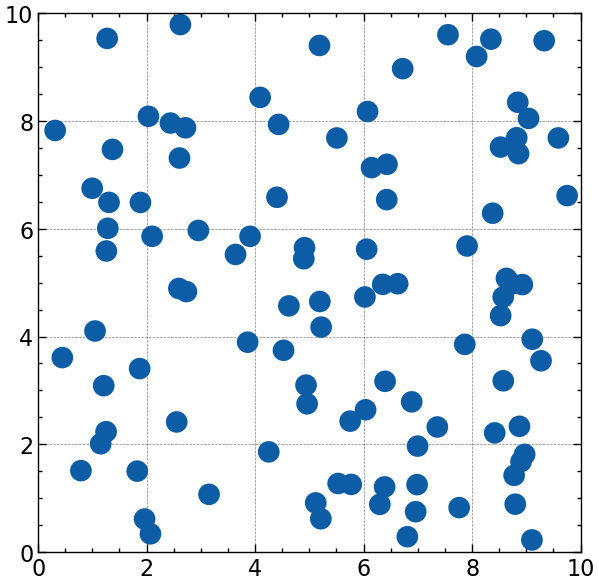

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
x, y = data[0][0], data[0][1]
circles = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(x, y)]  # creates circles centered at particles
circ = matplotlib.collections.PatchCollection(circles)
ax.add_collection(circ)
ax.set_xlim(0, box[0])
ax.set_ylim(0, box[1])
plt.show()

### Simulation

* Velocities after collision:
$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

* Functions used for simulation

In [6]:
def compute_new_v(v1, v2, r1, r2):
    """calculates velocity after collision"""
    v1_new = v1 - np.diag((v1-v2).T@(r1-r2))/np.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2_new = v2 - np.diag((v2-v1).T@(r2-r1))/np.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1_new, v2_new


def motion(r, v, ts, dt):
    """calculates position of each particle with time step dt"""
    rs = np.zeros((ts, r.shape[0], r.shape[1]))
    vs = np.zeros((ts, v.shape[0], v.shape[1]))
    # Initial State
    rs[0] = r.copy()
    vs[0] = v.copy()
    for i in range(1, ts):
        my_tree = KDTree(r.T)
        pairs = np.array(list(my_tree.query_pairs(r=2*radius)))  # finding collisions using nearest neighbour
        if pairs.size > 0:    
            v[:, pairs[:,0]], v[:, pairs[:,1]] = compute_new_v(v[:, pairs[:,0]], v[:, pairs[:,1]], r[:, pairs[:,0]], r[:,pairs[:,1]])

        # periodic boundary condition
        r[0, (r[0] + radius) > box[0]] = r[0, (r[0] + radius) > box[0]] - box[0]
        r[0, (r[0] - radius) < 0] = r[0, (r[0] - radius) < 0] + box[0]
        r[1, (r[1] + radius) > box[1]] = r[1, (r[1] + radius) > box[1]] - box[1]
        r[1, (r[1] - radius) < 0] = r[1, (r[1] - radius) < 0] + box[1]
        
        r = r + v*dt
        rs[i] = r.copy()
        vs[i] = v.copy()
    return rs, vs

In [7]:
rs, vs = motion(r=data[0], v=data[1], ts=steps, dt=0.2)

## Task II: radial distribution function

In [8]:
xs, ys = rs[-1][0], rs[-1][1]  # x, y positions at the end of simulation
max_r = box[0] / 2  # maximum radius for evaluating RDF
dr = 0.01  # thickness of rings
my_radius = np.arange(0, max_r + dr, dr)

### First

In [9]:
def rdf_1(n_particles, area, r, dr):
    gr = np.zeros(len(r))
    max_dist = r[-1] + dr /2
    particle_tree = KDTree(n_particles)

    for central_p in n_particles:
        
        nn_indices = particle_tree.query_ball_point(central_p, max_dist, p=2, eps=0)
        
        for neighbour in nn_indices:
            
            if np.any(np.not_equal(central_p, n_particles[neighbour])):
                
                dx = central_p[0] - n_particles[neighbour][0]
                dy = central_p[1] - n_particles[neighbour][1]
                d = np.sqrt(dx ** 2 + dy ** 2)
                idx_list = [i for i, j in enumerate(r) if np.abs(j - d) <= dr]
                for pos in idx_list:
                    
                    gr[pos] += 1
    
    gr[0] = 0
    
    for i in range (1 , len(r), 1):
        
        gr[i] /= len(n_particles)
    
        if r[i] - dr / 2 > 0:
        
            gr[i] /= np.pi * ((r[i] + dr / 2) ** 2 - (r[i] - dr / 2) ** 2)
        
        else:
            
            gr[i] /= np.pi * (r[i] + dr / 2) ** 2
    
    return gr * area / len(n_particles)

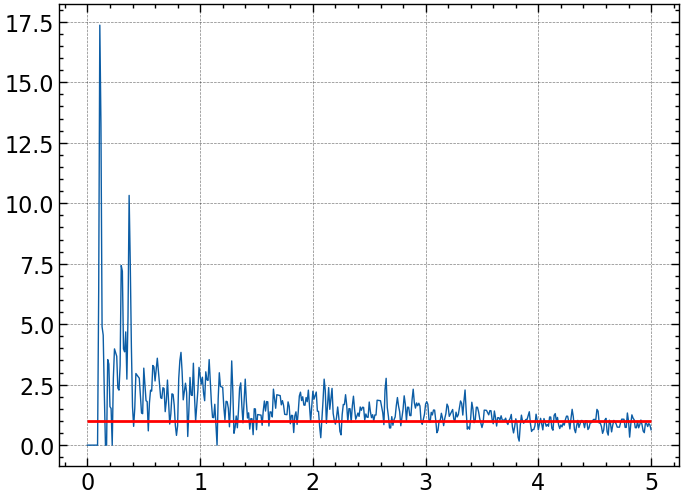

In [10]:
my_rdf_1 = rdf_1(np.array([xs, ys]).T, box[0]*box[1], my_radius, dr=0.01)
plt.plot(my_radius, my_rdf_1, '-', lw=1)
plt.hlines(1, 0, max_r, color='red')
plt.show()

### Second

In [11]:
s = box[0]
xs_image_r, xs_image_l = xs + s, xs - s
ys_image_t, ys_image_b = ys + s, ys - s

In [12]:
r_all = np.concatenate((np.array([xs, ys]).T, np.array([xs_image_r, ys]).T, np.array([xs_image_l, ys]).T,\
                        np.array([xs, ys_image_t]).T, np.array([xs, ys_image_b]).T, np.array([xs_image_r, ys_image_t]).T,\
                        np.array([xs_image_l, ys_image_b]).T, np.array([xs_image_r, ys_image_b]).T, np.array([xs_image_l, ys_image_t]).T))

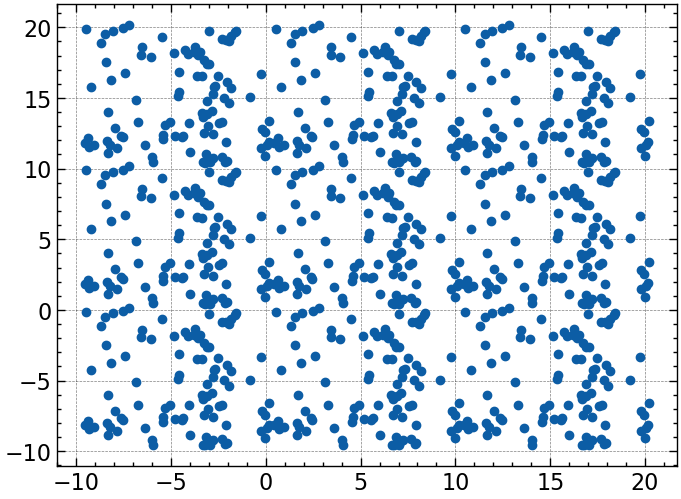

In [13]:
plt.plot(r_all.T[0], r_all.T[1], 'o')
plt.show()

In [14]:
def rdf_2(r_particles, area, r, dr):

    gr = np.zeros(len(r))
    max_dist = r[-1] + dr /2
    particle_tree = KDTree(r_particles)
    real_part = r_particles[:100]
    for central_p in real_part:
        
        nn_indices = particle_tree.query_ball_point(central_p, max_dist, p=2, eps=0)
        
        for neighbour in nn_indices:
            
            if np.any(np.not_equal(central_p, r_particles[neighbour])):
                
                dx = central_p[0] - r_particles[neighbour][0]
                dy = central_p[1] - r_particles[neighbour][1]
                d = np.sqrt(dx ** 2 + dy ** 2)
                idx_list = [i for i, j in enumerate(r) if np.abs(j - d) <= dr]
                for pos in idx_list:
                    
                    gr[pos] += 1
    
    gr[0] = 0
    
    for i in range (1 , len(r), 1):
        
        gr[i] /= len(real_part)
    
        if r[i] - dr / 2 > 0:
        
            gr[i] /= np.pi * ((r[i] + dr / 2) ** 2 - (r[i] - dr / 2) ** 2)
        
        else:
            
            gr[i] /= np.pi * (r[i] + dr / 2) ** 2
    
    return gr * area / len(real_part)

In [15]:
my_rdf_2 = rdf_2(r_all, box[0]*box[1], my_radius, dr=0.01)

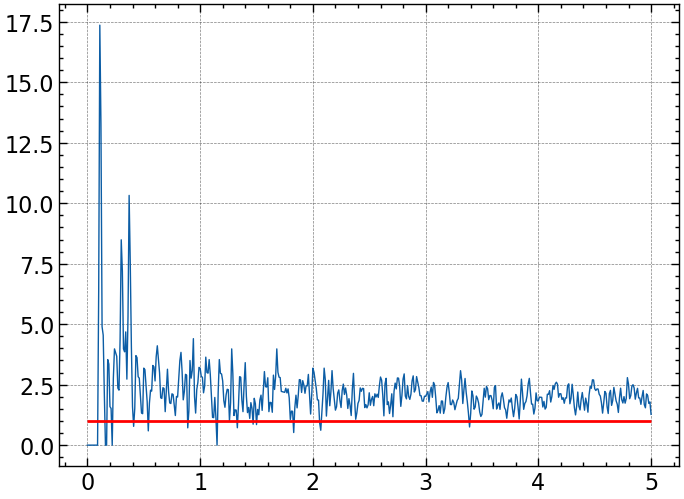

In [16]:
plt.plot(my_radius, my_rdf_2, '-', lw=1)
plt.hlines(1, 0, max_r, color='red')
plt.show()

###  Visualization

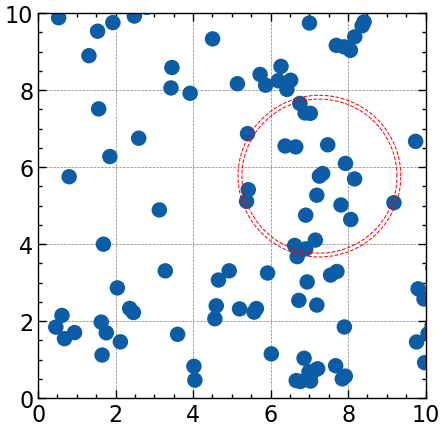

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
circles = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xs, ys)]
circ = matplotlib.collections.PatchCollection(circles)
ax.add_collection(circ)
ax.set_xlim(0, box[0])
ax.set_ylim(0, box[1])

theta = np.linspace(0, 2*np.pi, my_radius.size)
dr = 0.1
rad = 2
x0, y0 = xs[1], ys[1]
plt.plot(rad * np.cos(theta) + x0, rad * np.sin(theta) + y0, '--', c='red', linewidth=0.73)
plt.plot((rad+dr) * np.cos(theta) + x0, (rad+dr) * np.sin(theta) + y0, '--', c='red', linewidth=0.73)

plt.show()

## Task III: potential of mean force

* $\frac{3}{2}k_{B}T = KE_{avg} = N\frac{1}{2}m\bar{v^2}$

In [40]:
mass_mol = 0.002
N = particles
v_mean = np.mean(vs[0] ** 2 + vs[1] ** 2)
k_av = N * 0.5 * mass_mol * v_mean

In [41]:
k_av

0.025067234249642134

In [42]:
kb = 1.38 * 10 ** -23
temperature = (2 * k_av) / ( 3 * kb)

In [43]:
temperature

1.210977499982712e+21

In [44]:
fr = -kb * temperature * np.log(my_rdf_1)

C:\Users\Cirilla\AppData\Local\Temp\ipykernel_10380\2875616423.py:1: RuntimeWarning: divide by zero encountered in log
  fr = -kb * temperature * np.log(my_rdf_1)


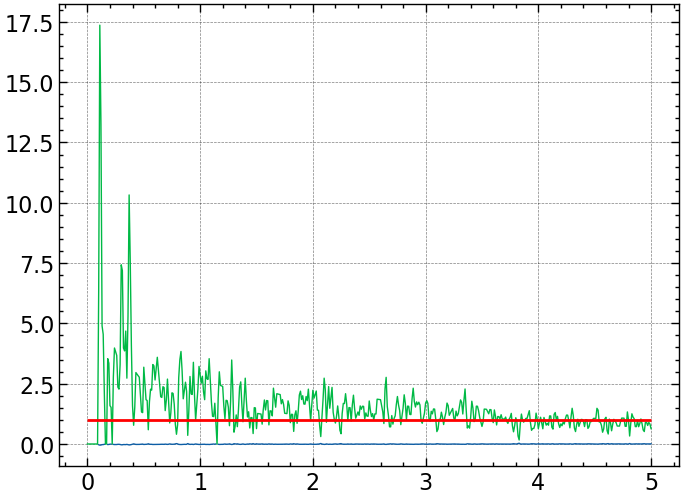

In [45]:
plt.plot(my_radius, fr, '-', lw=1)
plt.plot(my_radius, my_rdf_1, lw=1)
plt.hlines(1, 0, max_r, color='red')
plt.show()